In [1]:
import glob
import numpy as np
import pandas as pd
from scipy import stats

import os

import matplotlib.pyplot as plt

import rocks
rocks.set_log_level("error")
import time as t

from scipy.optimize import curve_fit


from astropy.time import Time
import requests
import io

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import angular_separation

from astropy.modeling import models, fitting
from scipy import special

from fink_utils.sso import spins as finkus
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
# G12 line in G1G2 space
def G12_to_G1G2(g12):

    G1_a, G2_a = 0.0, 0.53513350
    G1_b, G2_b = 0.84293649, -0.53513350

    G1 = G1_a + g12 * G1_b
    G2 = G2_a + g12 * G2_b

    return G1, G2

# Simple 1D Gaussian
def gauss(x, m, mu, sigma):
    return m * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Two 1D Gaussians
def double_gauss(x, m1, mu1, sigma1, m2, mu2, sigma2):
    g1 = gauss(x, m1, mu1, sigma1)
    g2 = gauss(x, m2, mu2, sigma2)
    return g1 + g2

# Get ZTF fit

In [3]:
# Local Configuration
bft_file = '/data/ssodnet/ssoBFT-latest.parquet'
data_fink = '/data/fink/spins/'
# data_fink = './'


In [4]:
# ZTF filters
filters = {'1': 'g', '2': 'r'}

S_color = {'g': -0.3928, 'r':0.2913}
sun_color = {'g': -0.3044, 'r':0.1903}

color_C = -(sun_color['g']-sun_color['r'])
color_S = -(S_color['g']-S_color['r'])


mag_to_V ={
        1: -0.2833,  # ZTF g
        2: 0.1777,   # ZTF r
        3: 0.4388,   # ATLAS orange
        4: -0.0986   # ATLAS cyan
    }

fink_colors = ['#15284F', '#F5622E']


In [5]:
data = pd.read_parquet(os.path.join(data_fink, 'data/ztf/sso_ZTF.parquet'))

In [6]:
data

,ssnamenr,nmeasurements,ndays,params,number,name,HG_H_g,HG_dH_g,HG_G_g,HG_dG_g,...,sHG1G2_err_R,sHG1G2_mean_cos_lambda,sHG1G2_alpha0,sHG1G2_status,sHG1G2_mean_delta_DEC,sHG1G2_sso_name,sHG1G2_sso_number,sHG1G2_obliquity,sHG1G2_version,sHG1G2_flag
0,95367,82,1037.766238,"{'G_1': 0.06303630024194717, 'G_2': 0.19601918...",95367,2002 CS157,15.205434,0.049852,6.303630e-02,0.065679,...,0.374610,0.530828,168.194550,2.0,0.037758,2002 CS157,95367.0,144.371020,0.2.0,0
1,250264,64,219.697303,"{'G_1': 0.22324514389038086, 'G_2': 0.31732639...",250264,2003 CV12,16.374287,0.171846,2.232451e-01,0.148994,...,NaN,NaN,NaN,2.0,-0.056794,2003 CV12,250264.0,90.270212,0.2.0,0
2,26487,208,1101.873183,"{'G_1': 0.33757442235946655, 'G_2': 0.33143043...",26487,2000 AV236,14.556883,0.039258,3.375744e-01,0.040907,...,0.232262,0.251356,119.838005,2.0,0.025000,2000 AV236,26487.0,163.426469,0.2.0,0
3,189809,63,1002.917616,"{'G_1': 2.0782619075841241e-16, 'G_2': 0.08747...",189809,2002 LO19,15.083442,0.085618,2.078262e-16,0.089987,...,0.660592,0.487807,160.719574,2.0,-0.024097,2002 LO19,189809.0,124.207359,0.2.0,0
4,34395,116,1087.781169,"{'G_1': 0.5242671966552734, 'G_2': 0.381103187...",34395,2000 RS73,15.081876,0.147779,5.242672e-01,0.206629,...,0.364133,0.162278,153.586975,2.0,0.011628,2000 RS73,34395.0,161.695699,0.2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115142,20866,216,1061.878310,"{'G_1': 0.25884151458740234, 'G_2': 0.40618246...",20866,2000 VP37,13.469830,0.094156,2.588415e-01,0.089800,...,0.044444,0.604874,101.739929,2.0,-0.015816,2000 VP37,20866.0,123.130044,0.2.0,0
115143,39790,96,1016.752407,"{'G_1': 0.08864176273345947, 'G_2': 0.03623726...",39790,1997 PF,13.892776,0.040307,8.864176e-02,0.039136,...,0.049193,0.634649,170.597214,2.0,-0.020341,1997 PF,39790.0,97.339610,0.2.0,0
115144,99263,65,794.646273,"{'G_1': 1.0, 'G_2': 0.8298622369766235, 'H_1':...",99263,2001 OZ31,17.481823,0.220211,1.000000e+00,0.380656,...,0.285201,0.224726,108.981400,2.0,0.063505,2001 OZ31,99263.0,40.075602,0.2.0,0
115145,18754,228,1181.814294,"{'G_1': 0.19368864595890045, 'G_2': 0.32351323...",18754,1999 GL21,14.145675,0.052304,1.936886e-01,0.048243,...,0.218130,0.392389,152.637390,2.0,0.047553,1999 GL21,18754.0,150.170732,0.2.0,0


In [7]:
bft = pd.read_parquet(bft_file)

cols = ['sso_number', 'sso_name', 'sso_class',
        'orbital_elements.semi_major_axis.value',
        'orbital_elements.eccentricity.value',
        'orbital_elements.inclination.value',
        'orbital_elements.node_longitude.value',
        'orbital_elements.perihelion_argument.value',
        'orbital_elements.mean_anomaly.value',
        'orbital_elements.mean_motion.value',
        'family.family_number', 'family.family_name',
        'tisserand_parameters.Jupiter.value',
        'albedo.value',
        'absolute_magnitude.value', 
        'diameter.value', 
        'taxonomy.class', 'taxonomy.complex', 'taxonomy.waverange', 'taxonomy.scheme', 'taxonomy.technique',
        'colors.g-r.color.value', 'colors.g-r.color.error.min', 'colors.g-r.color.error.max',
        'colors.g-r.facility', 'colors.g-r.observer', 'colors.g-r.epoch',
        'colors.g-r.delta_time', 'colors.g-r.id_filter_1',
        'colors.g-r.id_filter_2', 'colors.g-r.phot_sys', 'colors.g-r.technique',
        'spins.1.obliquity', 'spins.1.RA0.value', 'spins.1.DEC0.value',
        'spins.1.long.value', 'spins.1.lat.value', 'spins.1.technique',
        'spins.2.obliquity', 'spins.2.RA0.value', 'spins.2.DEC0.value',
        'spins.2.long.value', 'spins.2.lat.value', 'spins.2.technique',
        'spins.3.obliquity', 'spins.3.RA0.value', 'spins.3.DEC0.value',
        'spins.3.long.value', 'spins.3.lat.value', 'spins.3.technique',
        'spins.4.obliquity', 'spins.4.RA0.value', 'spins.4.DEC0.value',
        'spins.4.long.value', 'spins.4.lat.value', 'spins.4.technique'
       ] 

data = data.merge( bft[cols], left_on='name', right_on='sso_name', how='left' )


In [8]:
len(data)

115147

# Compare results

In [9]:
data.HG1G2_status.value_counts()

 2.0    106453
 4.0      6708
 1.0      1248
 3.0       497
-2.0       238
 0.0         3
Name: HG1G2_status, dtype: int64

In [11]:
thres = 1e-3

# HG Parameeter
mask_HG_g = (data.HG_H_g.notna()) & (data.HG_G_g.notna())
mask_HG_r = (data.HG_H_r.notna()) & (data.HG_G_r.notna())
mask_HG_fit = (data.HG_fit==0)  & (data.HG_status>=2)
mask_HG  = mask_HG_g & mask_HG_r & mask_HG_fit

# HG1G2 parameters
mask_HG1G2_g = (data.HG1G2_G1_g>thres)  & (data.HG1G2_G2_g>thres) & ((1-data.HG1G2_G1_g-data.HG1G2_G2_g)>thres)
mask_HG1G2_r = (data.HG1G2_G1_r>thres)  & (data.HG1G2_G2_r>thres) & ((1-data.HG1G2_G1_r-data.HG1G2_G2_r)>thres)
mask_HG1G2_fit = (data.HG1G2_fit==0)  & (data.HG1G2_status>=2)
mask_HG1G2 = mask_HG1G2_fit & mask_HG1G2_g & mask_HG1G2_r

# Hybrid ZTF
mask_sHG1G2_g = (data.sHG1G2_G1_g>thres)  & (data.sHG1G2_G2_g>thres) & ((1-data.sHG1G2_G1_g-data.sHG1G2_G2_g)>thres)
mask_sHG1G2_r = (data.sHG1G2_G1_r>thres)  & (data.sHG1G2_G2_r>thres) & ((1-data.sHG1G2_G1_r-data.sHG1G2_G2_r)>thres)
mask_sHG1G2_ZTF = mask_sHG1G2_g & mask_sHG1G2_r
mask_sHG1G2_fit = (data.sHG1G2_fit==0)  & (data.sHG1G2_status>=2)
mask_sHG1G2 = mask_sHG1G2_fit & mask_sHG1G2_ZTF 


# Spin solution suspicous: RA=={0,180,360}, DEC==0
maskSpin = (data.sHG1G2_alpha0>thres) & ( np.abs(360-data.sHG1G2_alpha0)>thres )  & \
           ( np.abs(data.sHG1G2_alpha0-180)>thres) & ( np.abs(data.sHG1G2_delta0)>thres ) 

# Phase coverage
maskPhase = data.minphase<2.5

# Global mask
mask = mask_HG1G2 & mask_sHG1G2


print(f' All data       : {len(data):6d}  ({100:>6.2f}%)')
print()
print(f'  Mask G g      : {len(data[mask_HG_g]):6d}  ({100.*len(data[mask_HG_g])/len(data):>6.2f}%)')
print(f'  Mask G r      : {len(data[mask_HG_r]):6d}  ({100.*len(data[mask_HG_r])/len(data):>6.2f}%)')
print(f'  Mask G g+r    : {len(data[mask_HG]):6d}  ({100.*len(data[mask_HG])/len(data):>6.2f}%)')
print()
print(f'  Mask G1G2 g   : {len(data[mask_HG1G2_g]):6d}  ({100.*len(data[mask_HG1G2_g])/len(data):>6.2f}%)')
print(f'  Mask G1G2 r   : {len(data[mask_HG1G2_r]):6d}  ({100.*len(data[mask_HG1G2_r])/len(data):>6.2f}%)')
print(f'  Mask G1G2 g+r : {len(data[mask_HG1G2]):6d}  ({100.*len(data[mask_HG1G2])/len(data):>6.2f}%)')
print()
print(f'  Mask hyb g    : {len(data[mask_sHG1G2_g]):6d}  ({100.*len(data[mask_sHG1G2_g])/len(data):>6.2f}%)')
print(f'  Mask hyb r    : {len(data[mask_sHG1G2_r]):6d}  ({100.*len(data[mask_sHG1G2_r])/len(data):>6.2f}%)')
print(f'  Mask hyb g+r  : {len(data[mask_sHG1G2]):6d}  ({100.*len(data[mask_sHG1G2])/len(data):>6.2f}%)')
print()
# print(f'  Mask hyb o    : {len(data_w_atlas[mask_HG1G2atlas_o]):6d}  ({100.*len(data_w_atlas[mask_HG1G2atlas_o])/len(data):>6.2f}%)')
# print(f'  Mask hyb c    : {len(data_w_atlas[mask_HG1G2atlas_c]):6d}  ({100.*len(data_w_atlas[mask_HG1G2atlas_c])/len(data):>6.2f}%)')
# print(f'  Mask hyb o+c  : {len(data_w_atlas[mask_HG1G2atlas_ATLAS]):6d}  ({100.*len(data_w_atlas[mask_HG1G2atlas_ATLAS])/len(data):>6.2f}%)')
# print()
# print(f'  Mask hyb groc : {len(data_w_atlas[mask_HG1G2atlas]):6d}  ({100.*len(data_w_atlas[mask_HG1G2atlas])/len(data):>6.2f}%)')
# print()
print(f'  Mask Spin     : {len(data[maskSpin]):6d}  ({100.*len(data[maskSpin])/len(data):>6.2f}%)')
print()
print(f'  Mask (both)   : {len(data[mask]):6d}  ({100.*len(data[mask])/len(data):>6.2f}%)')
for minphase in [2,3,4,5]:
    maskPhase = data.minphase<minphase
    print(f'  Mask phase {minphase}  : {len(data[maskPhase]):6d}  ({100.*len(data[maskPhase])/len(data):>6.2f}%)')


# len(data), len(data[mask]), len(data[mask_HG1G2]), len(data[mask_HG1G2sp]), len(data[mask_sHG1G2_g]), len(data[mask_sHG1G2_r]), len(data[mask_sHG1G2])

 All data       : 115147  (100.00%)

  Mask G g      : 114904  ( 99.79%)
  Mask G r      : 114906  ( 99.79%)
  Mask G g+r    : 112564  ( 97.76%)

  Mask G1G2 g   :  56815  ( 49.34%)
  Mask G1G2 r   :  62043  ( 53.88%)
  Mask G1G2 g+r :  40727  ( 35.37%)

  Mask hyb g    :  70735  ( 61.43%)
  Mask hyb r    :  75553  ( 65.61%)
  Mask hyb g+r  :  55601  ( 48.29%)

  Mask Spin     : 111365  ( 96.72%)

  Mask (both)   :  34702  ( 30.14%)
  Mask phase 2  :  57515  ( 49.95%)
  Mask phase 3  :  79455  ( 69.00%)
  Mask phase 4  :  93564  ( 81.26%)
  Mask phase 5  : 101933  ( 88.52%)


## Difference in absolute magnitude

In [12]:
data.columns[:40]

Index(['ssnamenr', 'nmeasurements', 'ndays', 'params', 'number', 'name',
       'HG_H_g', 'HG_dH_g', 'HG_G_g', 'HG_dG_g', 'HG_rms_g', 'HG_H_r',
       'HG_dH_r', 'HG_G_r', 'HG_dG_r', 'HG_rms_r', 'minphase', 'maxphase',
       'n_days', 'n_obs', 'HG_rms', 'HG_chi2red', 'HG_status', 'HG_fit',
       'HG1G2_H_g', 'HG1G2_dH_g', 'HG1G2_G1_g', 'HG1G2_dG1_g', 'HG1G2_G2_g',
       'HG1G2_dG2_g', 'HG1G2_rms_g', 'HG1G2_H_r', 'HG1G2_dH_r', 'HG1G2_G1_r',
       'HG1G2_dG1_r', 'HG1G2_G2_r', 'HG1G2_dG2_r', 'HG1G2_rms_r', 'HG1G2_rms',
       'HG1G2_chi2red'],
      dtype='object')

In [13]:
data[~mask_HG_r]

,ssnamenr,nmeasurements,ndays,params,number,name,HG_H_g,HG_dH_g,HG_G_g,HG_dG_g,...,spins.3.DEC0.value,spins.3.long.value,spins.3.lat.value,spins.3.technique,spins.4.obliquity,spins.4.RA0.value,spins.4.DEC0.value,spins.4.long.value,spins.4.lat.value,spins.4.technique
221,2017WM11,64,172.805868,"{'G_1': None, 'G_2': None, 'H_1': None, 'H_2':...",<NA>,2017 WM11,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
270,2013UX14,74,114.869768,"{'G_1': None, 'G_2': None, 'H_1': None, 'H_2':...",<NA>,2013 UX14,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
298,2014UK57,53,97.049201,"{'G_1': None, 'G_2': None, 'H_1': None, 'H_2':...",<NA>,2014 UK57,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
1038,2006QH99,72,171.718727,"{'G_1': None, 'G_2': None, 'H_1': None, 'H_2':...",<NA>,2006 QH99,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
1401,2012HV82,50,1025.808588,"{'G_1': None, 'G_2': None, 'H_1': None, 'H_2':...",<NA>,2012 HV82,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113086,2009CK44,95,235.790058,"{'G_1': None, 'G_2': None, 'H_1': None, 'H_2':...",<NA>,2009 CK44,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
113191,2011OP58,51,165.701898,"{'G_1': None, 'G_2': None, 'H_1': None, 'H_2':...",<NA>,2011 OP58,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
113271,2002PT87,76,119.800799,"{'G_1': None, 'G_2': None, 'H_1': None, 'H_2':...",595357,2002 PT87,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
113960,2007UE126,67,114.865532,"{'G_1': None, 'G_2': None, 'H_1': None, 'H_2':...",<NA>,2007 UE126,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None


In [14]:
data.columns[:80]

Index(['ssnamenr', 'nmeasurements', 'ndays', 'params', 'number', 'name',
       'HG_H_g', 'HG_dH_g', 'HG_G_g', 'HG_dG_g', 'HG_rms_g', 'HG_H_r',
       'HG_dH_r', 'HG_G_r', 'HG_dG_r', 'HG_rms_r', 'minphase', 'maxphase',
       'n_days', 'n_obs', 'HG_rms', 'HG_chi2red', 'HG_status', 'HG_fit',
       'HG1G2_H_g', 'HG1G2_dH_g', 'HG1G2_G1_g', 'HG1G2_dG1_g', 'HG1G2_G2_g',
       'HG1G2_dG2_g', 'HG1G2_rms_g', 'HG1G2_H_r', 'HG1G2_dH_r', 'HG1G2_G1_r',
       'HG1G2_dG1_r', 'HG1G2_G2_r', 'HG1G2_dG2_r', 'HG1G2_rms_r', 'HG1G2_rms',
       'HG1G2_chi2red', 'HG1G2_status', 'HG1G2_fit', 'sHG1G2_max_phase_1',
       'sHG1G2_kurtosis_delta_RA_cos_DEC', 'sHG1G2_max_phase_2',
       'sHG1G2_max_cos_lambda', 'sHG1G2_fit', 'sHG1G2_R',
       'sHG1G2_min_cos_lambda', 'sHG1G2_kurtosis_delta_DEC', 'sHG1G2_n_obs',
       'sHG1G2_skew_delta_DEC', 'sHG1G2_err_G2_1', 'sHG1G2_err_G1_2',
       'sHG1G2_skew_delta_RA_cos_DEC', 'sHG1G2_n_days', 'sHG1G2_err_G1_1',
       'sHG1G2_rms', 'sHG1G2_err_G2_2', 'sHG1G2_G2_g',

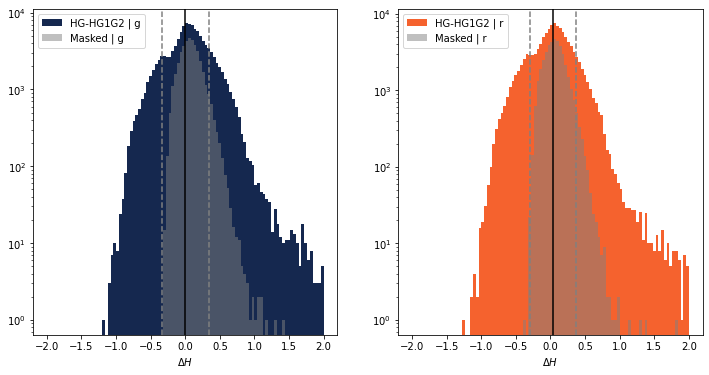

In [15]:
# HG vs HG1G2
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'HG_H_{f}'] - data[f'HG1G2_H_{f}']

    hn, hb, _ = ax[i].hist( x, range=r, bins=b, label=f'HG-HG1G2 | {f}', color=fink_colors[i] )
    statarr.append([hb[ np.argmax(hn) ], np.std(x)])

    ax[i].hist( x[mask_HG1G2], range=r, bins=b, label=f'Masked | {f}', color='grey', alpha=0.5 )

    ax[i].axvline( statarr[i][0], color='black' )
    ax[i].axvline( statarr[i][0]-statarr[i][1], color='gray', linestyle='dashed' )
    ax[i].axvline( statarr[i][0]+statarr[i][1], color='gray', linestyle='dashed' )
    
for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    a.set_yscale('log')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'eltaH_HG_HG1G2.png'), facecolor='white')

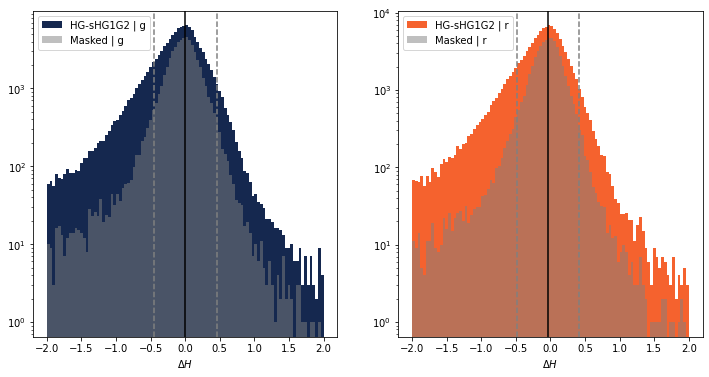

In [16]:
# HG vs HG1G2hyb
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'HG_H_{f}'] - data[f'sHG1G2_H_{f}']

    hn, hb, _ = ax[i].hist( x, range=r, bins=b, label=f'HG-sHG1G2 | {f}', color=fink_colors[i] )
    statarr.append([hb[ np.argmax(hn) ], np.std(x)])

    ax[i].hist( x[mask_sHG1G2], range=r, bins=b, label=f'Masked | {f}', color='grey', alpha=0.5 )
    
    ax[i].axvline( statarr[i][0], color='black' )
    ax[i].axvline( statarr[i][0]-statarr[i][1], color='gray', linestyle='dashed' )
    ax[i].axvline( statarr[i][0]+statarr[i][1], color='gray', linestyle='dashed' )
    
for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    a.set_yscale('log')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'deltaH_HG_sHG1G2.png'), facecolor='white')

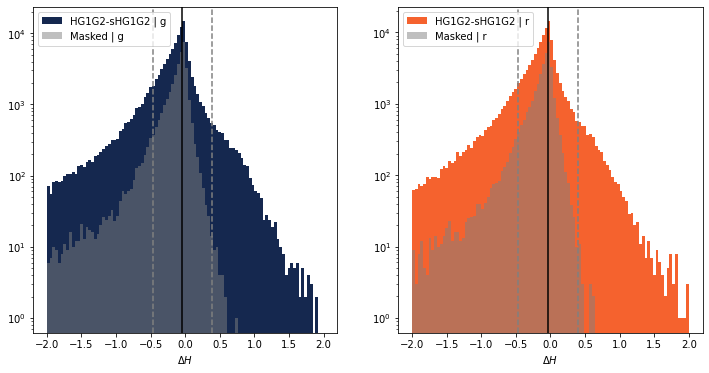

In [17]:
# HG vs HG1G2hyb
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'HG1G2_H_{f}'] - data[f'sHG1G2_H_{f}']

    hn, hb, _ = ax[i].hist( x, range=r, bins=b, label=f'HG1G2-sHG1G2 | {f}', color=fink_colors[i] )
    statarr.append([hb[ np.argmax(hn) ], np.std(x)])

    ax[i].hist( x[mask_HG1G2&mask_sHG1G2], range=r, bins=b, label=f'Masked | {f}', color='grey', alpha=0.5 )

    ax[i].axvline( statarr[i][0], color='black' )
    ax[i].axvline( statarr[i][0]-statarr[i][1], color='gray', linestyle='dashed' )
    ax[i].axvline( statarr[i][0]+statarr[i][1], color='gray', linestyle='dashed' )
    
for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    a.set_yscale('log')
    
fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'deltaH_HG1G2_sHG1G2.png'), facecolor='white')

- HG seems to fail as expected
- HG1G2 vs spin non symmetric: effect of oppositions
- Hspin often smaller

Apparently a systematic larger value of H (HG) wrt H (hybrid)

H_s = m - f - g - s
    = H - s

so
H_S - H = - s
 s s always negative -> H_S - H > 0
  
unless the issues with geometry are modifying g, so everything is messed up in non-hybrid model!
  

1 HG_H_r HG1G2_H_r
2 HG_H_r sHG1G2_H_r
3 HG1G2_H_r sHG1G2_H_r


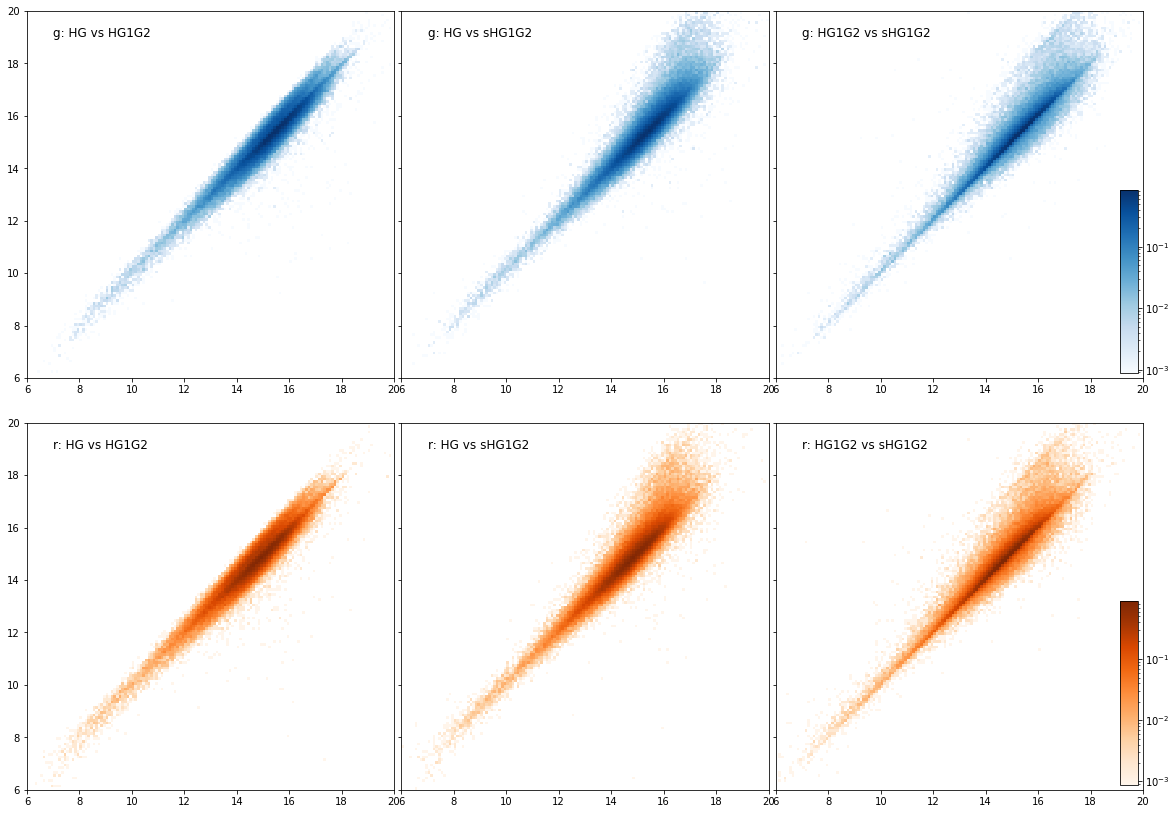

In [19]:
fig, ax = plt.subplots(2, 3, figsize=(20,15), gridspec_kw={'hspace':0.02, 'wspace':0.02})

hh_r = [ [0,22], [0,22] ]
bb_r = np.array([1,1]) * 88
xlab, ylab = 2,20

hh_r = [ [6,20], [6,20] ]
bb_r = np.array([1,1]) * (hh_r[0][1] - hh_r[0][0])*10
xlab, ylab = 7,19

models = ['HG','HG1G2','sHG1G2']
for i in range(3):
    for j in range(i+1,3):

        mx = models[i]
        my = models[j]
        loc_f = 'r'
        print( i+j, f'{mx}_H_{loc_f}', f'{my}_H_{loc_f}' )
        
        # Filter g
        x = data[f'{mx}_H_g']
        y = data[f'{my}_H_g']
        loc_cmap = 'Blues' 
        _ , _, _, img = ax[0,i+j-1].hist2d( x, y, range=hh_r, bins=bb_r, cmap=loc_cmap, norm='log', density=True )
        ax[0,i+j-1].text( xlab, ylab, f'g: {mx} vs {my}', fontsize='large' )
        
        # Filter r
        x = data[f'{mx}_H_r']
        y = data[f'{my}_H_r']
        loc_cmap = 'Oranges' 
        _ , _, _, imr = ax[1,i+j-1].hist2d( x, y, range=hh_r, bins=bb_r, cmap=loc_cmap, norm='log', density=True )
        ax[1,i+j-1].text( xlab, ylab, f'r: {mx} vs {my}', fontsize='large' )

        ax[0,i+j-1].set_aspect('equal')
        ax[1,i+j-1].set_aspect('equal')
        
        if (i+j-1)>0:
            ax[0,i+j-1].set_yticklabels('')
            ax[1,i+j-1].set_yticklabels('')
    
axinsg = inset_axes(
    ax[0,2],
    width="5%",  # width: 50% of parent_bbox width
    height="50%",  # height: 5%
    loc="lower right",
)
fig.colorbar(img, cax=axinsg)


axinsr = inset_axes(
    ax[1,2],
    width="5%",  # width: 50% of parent_bbox width
    height="50%",  # height: 5%
    loc="lower right",
)
fig.colorbar(imr, cax=axinsr)

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'scatterH_HG1G2_sHG1G2.png'), facecolor='white')

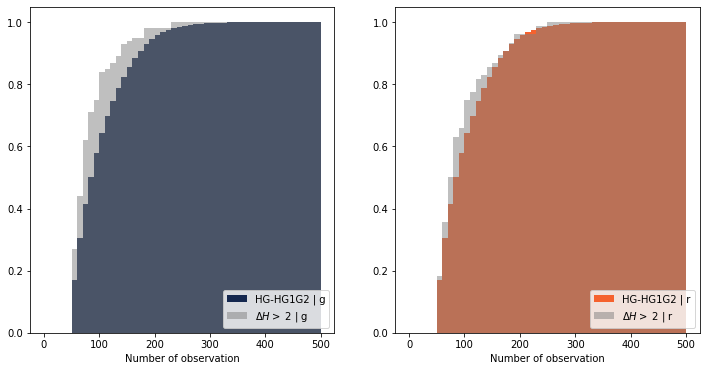

In [20]:
# HG vs HG1G2
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [0,500]
b = 50
lim_delta_H = 2

statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'HG_H_{f}'] - data[f'HG1G2_H_{f}']
    cond = np.abs(x) > lim_delta_H
    
    ax[i].hist( data['n_obs'], range=r, bins=b, label=f'HG-HG1G2 | {f}', color=fink_colors[i], density=True, cumulative=True )
    ax[i].hist( data.loc[cond, 'n_obs'], range=r, bins=b, label=f'$\Delta H >$ {lim_delta_H} | {f}', color='grey', alpha=0.5, density=True, cumulative=True )

    ax[i].set_xlabel('Number of observation')
    ax[i].legend(loc='lower right')
    
fig.savefig( os.path.join(data_fink, 'gfx', 'data', 'n_obs.png'), facecolor='white')

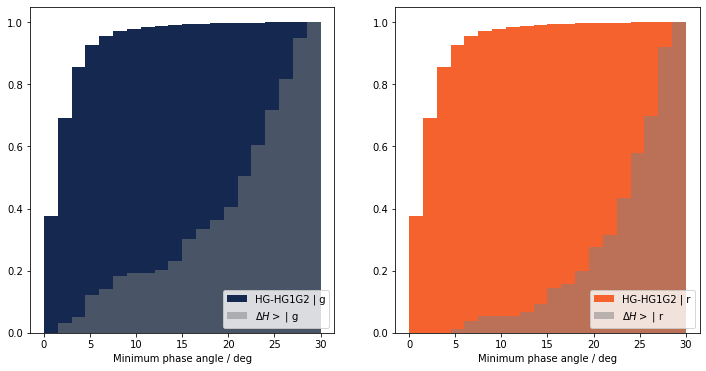

In [21]:
# HG vs HG1G2
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [0,30]
b = 20
lim_delta_H = 2

statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'HG_H_{f}'] - data[f'HG1G2_H_{f}']
    cond = np.abs(x) > lim_delta_H
    
    ax[i].hist( data['minphase'], range=r, bins=b, label=f'HG-HG1G2 | {f}', color=fink_colors[i], density=True, cumulative=True )
    ax[i].hist( data.loc[cond, 'minphase'], range=r, bins=b, label=f'$\Delta H >$ | {f}', color='grey', alpha=0.5, density=True, cumulative=True )
    ax[i].legend(loc='lower right')

    ax[i].set_xlabel('Minimum phase angle / deg')
    
fig.savefig( os.path.join(data_fink, 'gfx', 'data', 'min_phase.png'), facecolor='white')

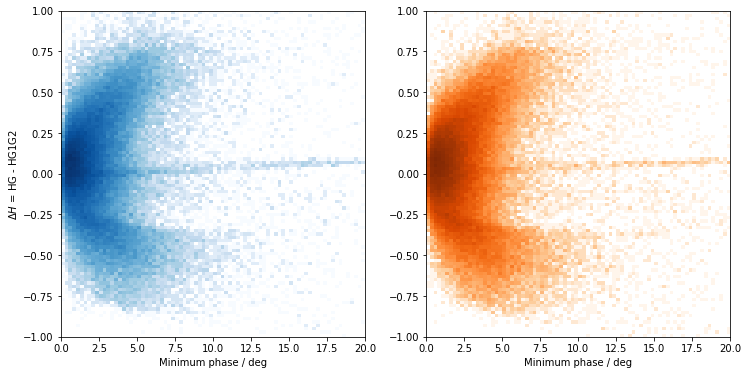

In [22]:
# HG vs HG1G2
fig, ax = plt.subplots(1, 2, figsize=(12,6))

hh_r = [ [0,20], [-1,1] ]
bb_r = [80,100]
xlab, ylab = 2,20


statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'minphase']
    y = data[f'HG_H_{f}'] - data[f'HG1G2_H_{f}']

    if f=='g':
        loc_cmap = 'Blues' 
    else:
        loc_cmap = 'Oranges' 
    ax[i].hist2d( x, y, range=hh_r, bins=bb_r, cmap=loc_cmap, norm='log', density=True )

    ax[i].set_xlabel('Minimum phase / deg')
    
ax[0].set_ylabel('$\Delta H$ = HG - HG1G2')

fig.savefig( os.path.join(data_fink, 'gfx', 'data', 'deltaH_vs_phase_HG_HG1G2.png'), facecolor='white')

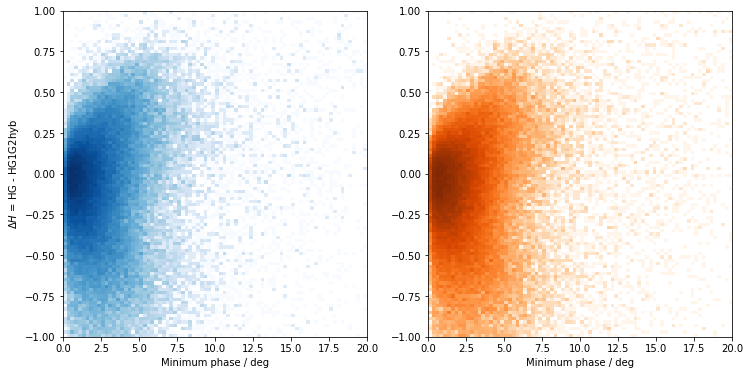

In [23]:
# HG vs HG1G2
fig, ax = plt.subplots(1, 2, figsize=(12,6))

hh_r = [ [0,20], [-1,1] ]
bb_r = [80,100]
xlab, ylab = 2,20


statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'minphase']
    y = data[f'HG_H_{f}'] - data[f'sHG1G2_H_{f}']

    if f=='g':
        loc_cmap = 'Blues' 
    else:
        loc_cmap = 'Oranges' 
    ax[i].hist2d( x, y, range=hh_r, bins=bb_r, cmap=loc_cmap, norm='log', density=True )

    ax[i].set_xlabel('Minimum phase / deg')
    
ax[0].set_ylabel('$\Delta H$ = HG - HG1G2hyb')

fig.savefig( os.path.join(data_fink, 'gfx', 'data', 'deltaH_vs_phase_HG_sHG1G2.png'), facecolor='white')

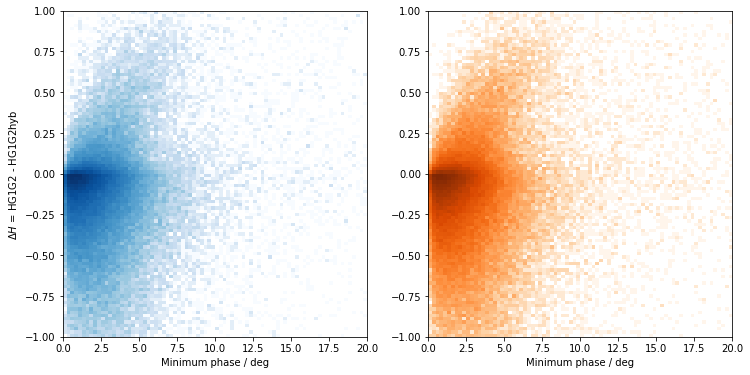

In [24]:
# HG vs HG1G2
fig, ax = plt.subplots(1, 2, figsize=(12,6))

hh_r = [ [0,20], [-1,1] ]
bb_r = [80,100]
xlab, ylab = 2,20


statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'minphase']
    y = data[f'HG1G2_H_{f}'] - data[f'sHG1G2_H_{f}']

    if f=='g':
        loc_cmap = 'Blues' 
    else:
        loc_cmap = 'Oranges' 
    ax[i].hist2d( x, y, range=hh_r, bins=bb_r, cmap=loc_cmap, norm='log', density=True )

    ax[i].set_xlabel('Minimum phase / deg')
    
ax[0].set_ylabel('$\Delta H$ = HG1G2 - HG1G2hyb')

fig.savefig( os.path.join(data_fink, 'gfx', 'data', 'deltaH_vs_phase_HG1G2_sHG1G2.png'), facecolor='white')

## Colors

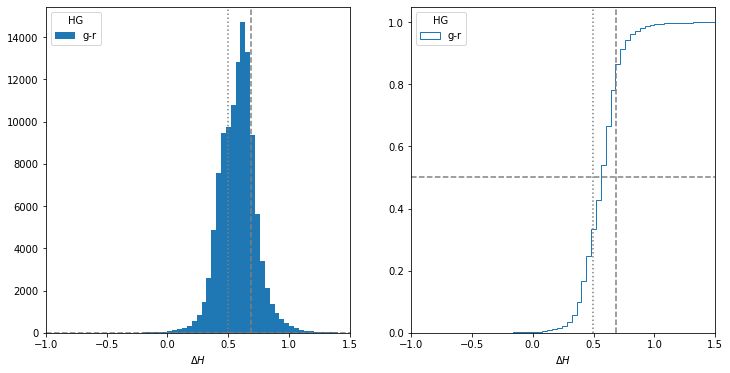

In [25]:
# HG colors vs expectations
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

x = data.HG_H_g - data.HG_H_r
ax[0].hist( x, range=r, bins=b, label='g-r' )
ax[1].hist( x, range=r, bins=b, density=True, cumulative=True, histtype='step', label='g-r' )

for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left', title='HG')
    a.set_xlim( -1, 1.5 )
    a.axhline(0.5, color='gray', linestyle='--')
    a.axvline( -(S_color['g']-S_color['r']), color='gray', linestyle='dashed', label='S types')
    a.axvline( -(sun_color['g']-sun_color['r']), color='gray', linestyle='dotted', label='C types')

# ax[0].set_yscale('log')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'color_HG.png'), facecolor='white')

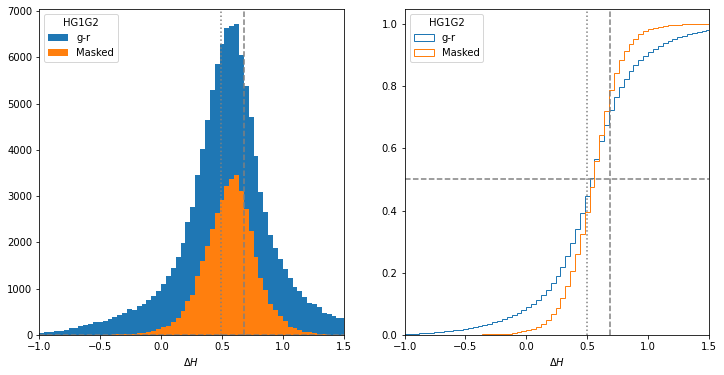

In [26]:
# HG1G2 colors vs expectations
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

x = data.HG1G2_H_g - data.HG1G2_H_r
loc_mask = mask_HG1G2
ax[0].hist( x, range=r, bins=b, label='g-r' )
ax[0].hist( x[loc_mask], range=r, bins=b, label='Masked' )

ax[1].hist( x, range=r, bins=b, density=True, cumulative=True, histtype='step', label='g-r' )
ax[1].hist( x[loc_mask], range=r, bins=b, density=True, cumulative=True, histtype='step', label='Masked' )


for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left', title='HG1G2')
    a.set_xlim( -1, 1.5 )
    a.axhline(0.5, color='gray', linestyle='--')
    a.axvline( -(S_color['g']-S_color['r']), color='gray', linestyle='dashed', label='S types')
    a.axvline( -(sun_color['g']-sun_color['r']), color='gray', linestyle='dotted', label='C types')

# ax[0].set_yscale('log')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'color_HG1G2.png'), facecolor='white')

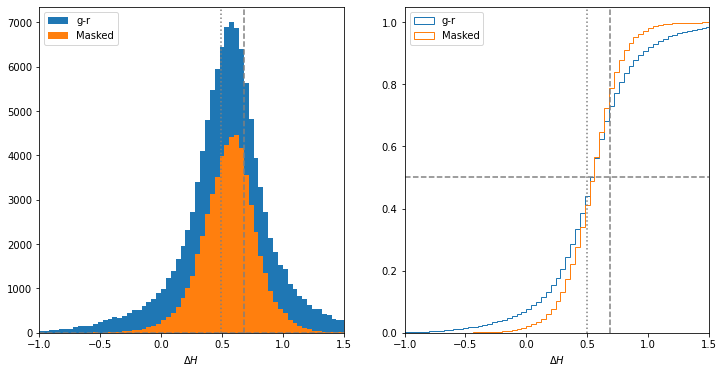

In [27]:
# Hybrid colors vs expectations
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

x = data.sHG1G2_H_g - data.sHG1G2_H_r
loc_mask = mask_sHG1G2 & (data.minphase<2.5) # Test minphase influence
loc_mask = mask_sHG1G2 

ax[0].hist( x, range=r, bins=b, label='g-r' )
ax[0].hist( x[loc_mask], range=r, bins=b, label='Masked' )

ax[1].hist( x, range=r, bins=b, density=True, cumulative=True, histtype='step', label='g-r' )
ax[1].hist( x[loc_mask], range=r, bins=b, density=True, cumulative=True, histtype='step', label='Masked' )


for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    a.set_xlim( -1, 1.5 )
    a.axhline(0.5, color='gray', linestyle='--')
    a.axvline( -(S_color['g']-S_color['r']), color='gray', linestyle='dashed', label='S types')
    a.axvline( -(sun_color['g']-sun_color['r']), color='gray', linestyle='dotted', label='C types')

# ax[0].set_yscale('log')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'color_sHG1G2.png'), facecolor='white')

In [29]:
data.columns[:80]

Index(['ssnamenr', 'nmeasurements', 'ndays', 'params', 'number', 'name',
       'HG_H_g', 'HG_dH_g', 'HG_G_g', 'HG_dG_g', 'HG_rms_g', 'HG_H_r',
       'HG_dH_r', 'HG_G_r', 'HG_dG_r', 'HG_rms_r', 'minphase', 'maxphase',
       'n_days', 'n_obs', 'HG_rms', 'HG_chi2red', 'HG_status', 'HG_fit',
       'HG1G2_H_g', 'HG1G2_dH_g', 'HG1G2_G1_g', 'HG1G2_dG1_g', 'HG1G2_G2_g',
       'HG1G2_dG2_g', 'HG1G2_rms_g', 'HG1G2_H_r', 'HG1G2_dH_r', 'HG1G2_G1_r',
       'HG1G2_dG1_r', 'HG1G2_G2_r', 'HG1G2_dG2_r', 'HG1G2_rms_r', 'HG1G2_rms',
       'HG1G2_chi2red', 'HG1G2_status', 'HG1G2_fit', 'sHG1G2_max_phase_1',
       'sHG1G2_kurtosis_delta_RA_cos_DEC', 'sHG1G2_max_phase_2',
       'sHG1G2_max_cos_lambda', 'sHG1G2_fit', 'sHG1G2_R',
       'sHG1G2_min_cos_lambda', 'sHG1G2_kurtosis_delta_DEC', 'sHG1G2_n_obs',
       'sHG1G2_skew_delta_DEC', 'sHG1G2_err_G2_1', 'sHG1G2_err_G1_2',
       'sHG1G2_skew_delta_RA_cos_DEC', 'sHG1G2_n_days', 'sHG1G2_err_G1_1',
       'sHG1G2_rms', 'sHG1G2_err_G2_2', 'sHG1G2_G2_g',

KeyError: 'sHG1G2_dH_g'

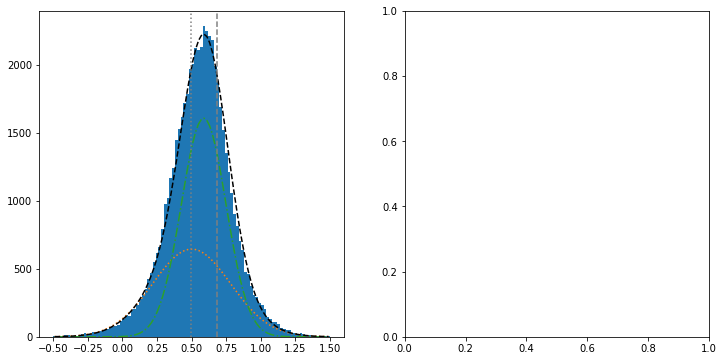

In [28]:
# Hybrid colors vs expectations
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-0.5,1.5]
b = 100

cond = mask_sHG1G2
dH = data.loc[cond,'sHG1G2_H_g'] - data.loc[cond,'sHG1G2_H_r']
bin_values, bin_boundaries, _ = ax[0].hist( dH, range=r, bins=b, label='H_g-H_r / maskHyb' )


# bin_values, bin_boundaries = np.histogram(dH, bins=b)
x = bin_boundaries[:-1] + 0.5*(bin_boundaries[1] - bin_boundaries[0])
popt, pcov = curve_fit(
    double_gauss, 
    x, 
    bin_values, 
    p0=[1000, color_C, 0.1, 1000, color_S, 0.1], 
    bounds=([0, 0, 0, 0.5, 0, 0], [1e5, 0.5, 1.5, 1e5, 1.0, 1.5])
)
ax[0].plot(x, gauss(x, *popt[:3]), label='C ({:.2f},{:.2f})'.format(popt[1],popt[2]), ls='dotted')
ax[0].plot(x, gauss(x, *popt[3:]), label='S ({:.2f},{:.2f})'.format(popt[4],popt[5]), ls='dashdot')
ax[0].plot(x, double_gauss(bin_boundaries[:-1], *popt), ls='--', color='black')

ax[0].axvline( color_C, color='gray', linestyle='dotted', label='C types')
ax[0].axvline( color_S, color='gray', linestyle='dashed', label='S types')


unc_H = 0.2
cond = mask_sHG1G2 * \
       (data['sHG1G2_dH_g']<unc_H) * \
       (data['sHG1G2_dH_r']<unc_H)
dH = data.loc[cond,'sHG1G2_H_g'] - data.loc[cond,'sHG1G2_H_r']
bin_values, bin_boundaries, _ = ax[1].hist( dH, range=r, bins=b, label=f'H_g-H_r / $\sigma={unc_H:.2f}$' )
print('N with colors: ', len(data[cond]) )

# bin_values, bin_boundaries = np.histogram(dH, bins=b)
x = bin_boundaries[:-1] + 0.5*(bin_boundaries[1] - bin_boundaries[0])
popt, pcov = curve_fit(
    double_gauss, 
    x, 
    bin_values, 
    p0=[1000, color_C, 0.1, 1000, color_S, 0.1], 
    bounds=([0, 0, 0, 0.5, 0, 0], [1e5, 0.5, 1.5, 1e5, 1.0, 1.5])
)
ax[1].plot(x, gauss(x, *popt[:3]), label='C ({:.2f},{:.2f})'.format(popt[1],popt[2]), color='k', ls='dotted')
ax[1].plot(x, gauss(x, *popt[3:]), label='S ({:.2f},{:.2f})'.format(popt[4],popt[5]), color='k', ls='dashdot')
ax[1].plot(x, double_gauss(bin_boundaries[:-1], *popt), ls='--', color='black')

# ax[1].axvline( color_C, color='gray', linestyle='dotted', label='C types')
# ax[1].axvline( color_S, color='gray', linestyle='dashed', label='S types')



# ----
sqrt2 = np.sqrt(2.0)
A1 = popt[0]
mu1 = popt[1]
std1 = popt[2]

A2 = popt[3]
mu2 = popt[4]
std2 = popt[5]


x1 = (data['sHG1G2_H_g'] - data['sHG1G2_H_r']) - (data['sHG1G2_dH_g'] - data['sHG1G2_dH_r'])
x2 = (data['sHG1G2_H_g'] - data['sHG1G2_H_r']) + (data['sHG1G2_dH_g'] - data['sHG1G2_dH_r'])

pC = (A1*special.erf((x2 - mu1) / (sqrt2 * std1)) - 
          A1*special.erf((x1 - mu1) / (sqrt2 * std1)))
pS = (A2*special.erf((x2 - mu2) / (sqrt2 * std2)) - 
          A2*special.erf((x1 - mu2) / (sqrt2 * std2)))

# Add Class to DataFrame
data['ztf_pC'] = 0.0
data['ztf_pS'] = 0.0
data['ztf_complex'] = 'U'

cond_z = (pC + pS) > 0
data.loc[cond_z, 'ztf_pC'] = pC[cond_z] / (pC[cond_z] + pS[cond_z])
data.loc[cond_z, 'ztf_pS'] = pS[cond_z] / (pC[cond_z] + pS[cond_z])

rate = 0.2
condS = data['ztf_pS'] - data['ztf_pC'] > rate
data.loc[condS, 'ztf_complex'] = 'S'
data.loc[condS, 'ztf_pcomplex'] = data.loc[cond, 'ztf_pS']
condC = data['ztf_pC'] - data['ztf_pS'] > rate
data.loc[condC, 'ztf_complex'] = 'C'

#cleaning

data.loc[~cond,'ztf_complex'] = 'U'

cond = mask_sHG1G2 * \
       (data['sHG1G2_dH_g']<unc_H) * \
       (data['sHG1G2_dH_r']<unc_H) * \
       (data['ztf_complex']=='C')
dH = data.loc[cond,'sHG1G2_H_g'] - data.loc[cond,'sHG1G2_H_r']
bin_values, bin_boundaries, _ = ax[1].hist( dH, range=r, bins=b, color='gray' )

cond = mask_sHG1G2 * \
       (data['sHG1G2_dH_g']<unc_H) * \
       (data['sHG1G2_dH_r']<unc_H) * \
       (data['ztf_complex']=='S')
dH = data.loc[cond,'sHG1G2_H_g'] - data.loc[cond,'sHG1G2_H_r']
bin_values, bin_boundaries, _ = ax[1].hist( dH, range=r, bins=b, color='orange' )


for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    a.axhline(0.5, color='gray', linestyle='--')
    a.set_xlim(0,1)

# fig.savefig(f'{data_fink}/gfx_models/deltaH_g_r.png', facecolor='white')

data['ztf_complex'].value_counts()


In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12,12), gridspec_kw={'hspace':0.02})

s = 20
alpha = 0.5
alp = 0.5
C = (data['ztf_complex'] == 'C')
S = (data['ztf_complex'] == 'S')

# a i
ax[0].scatter( data.loc[S,'orbital_elements.semi_major_axis.value'], 
               data.loc[S,'orbital_elements.inclination.value'], color='red', label='S', marker='.', s=s, alpha=alpha)
ax[0].scatter( data.loc[C,'orbital_elements.semi_major_axis.value'], 
               data.loc[C,'orbital_elements.inclination.value'], color='blue', label='C', marker='.', s=s, alpha=alpha)

# hist a
r = [2,3.7]
b = 17
ax[1].hist( data.loc[S,'orbital_elements.semi_major_axis.value'], range=r, bins=b, color='red', label='S', alpha=alp )
ax[1].hist( data.loc[C,'orbital_elements.semi_major_axis.value'], range=r, bins=b, color='blue', label='C', alpha=alp )

# a e
# ax[1].scatter( data.loc[S,'orbital_elements.semi_major_axis.value'], 
#                data.loc[S,'orbital_elements.eccentricity.value'], color='red', label='S', marker='.', s=s, alpha=alpha)
# ax[1].scatter( data.loc[C,'orbital_elements.semi_major_axis.value'], 
#                data.loc[C,'orbital_elements.eccentricity.value'], color='blue', label='C', marker='.', s=s, alpha=alpha)

for a in ax:
    a.set_xlim(r)
    a.legend(loc='upper left')

ax[0].set_ylim(0,30)
# ax[1].set_ylim(0,0.6)
ax[0].set_xlabel('Semi-major axis / au')
ax[0].set_xlabel('Inclination / deg')
ax[1].set_xlabel('Eccentricity')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'aei_C_S.png'), facecolor='white')

# G1G2 distribution

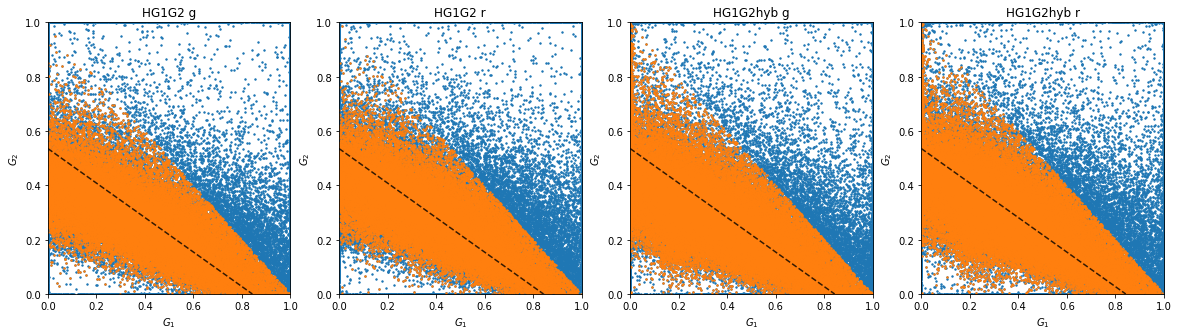

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))

r = [-2,2]
b = 100


x = data.HG1G2_G1_g
y = data.HG1G2_G2_g
ax[0].scatter( x, y, s=2 )
ax[0].scatter( x[mask_HG1G2], y[mask_HG1G2], s=2 )
ax[0].set_title('HG1G2 g', ha='center', fontsize='large') 

x = data.HG1G2_G1_r
y = data.HG1G2_G2_r
ax[1].scatter( x, y, s=2 )
ax[1].scatter( x[mask_HG1G2], y[mask_HG1G2], s=2 )
ax[1].set_title('HG1G2 r', ha='center', fontsize='large') 

x = data.sHG1G2_G1_g
y = data.sHG1G2_G2_g
ax[2].scatter( x, y, s=2 )
ax[2].scatter( x[mask_sHG1G2], y[mask_sHG1G2], s=2 )
ax[2].set_title('HG1G2hyb g', ha='center', fontsize='large') 

x = data.sHG1G2_G1_r
y = data.sHG1G2_G2_r
ax[3].scatter( x, y, s=2 )
ax[3].scatter( x[mask_sHG1G2], y[mask_sHG1G2], s=2 )
ax[3].set_title('HG1G2hyb r', ha='center', fontsize='large') 


for a in ax:
    a.set_xlabel('$G_1$')
    a.set_ylabel('$G_2$')
    a.set_xlim(0,1)
    a.set_ylim(0,1)
    
    # G12 line
    xx = np.linspace(0,1,num=5)    
    G1, G2 = G12_to_G1G2(xx)
    a.plot(G1, G2, linestyle="--", color="black", alpha=0.8)

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'G1G2_scatter.png'), facecolor='white')

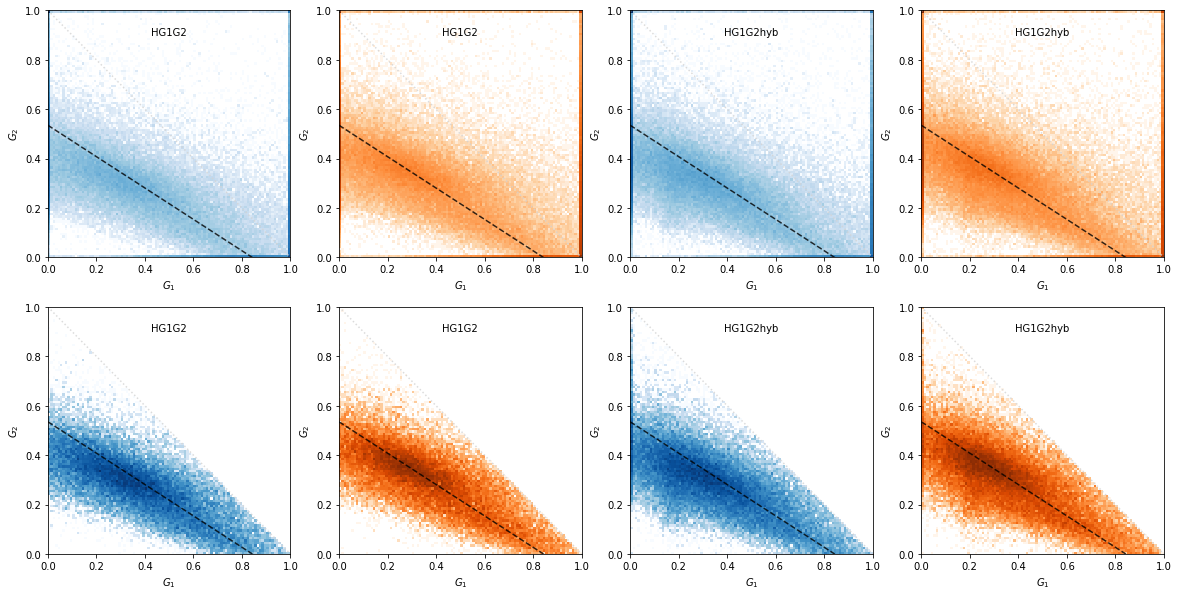

In [31]:
fig, ax = plt.subplots(2, 4, figsize=(20,10))

r = [0,1]
b = 100


x = data.HG1G2_G1_g
y = data.HG1G2_G2_g
ax[0,0].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Blues' )
ax[1,0].hist2d( x[mask_HG1G2], y[mask_HG1G2], range=[r,r], bins=b, norm='log', cmap='Blues' )

x = data.HG1G2_G1_r
y = data.HG1G2_G2_r
ax[0,1].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Oranges' )
ax[1,1].hist2d( x[mask_HG1G2], y[mask_HG1G2], range=[r,r], bins=b, norm='log', cmap='Oranges' )

x = data.sHG1G2_G1_g
y = data.sHG1G2_G2_g
ax[0,2].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Blues' )
ax[1,2].hist2d( x[mask_sHG1G2], y[mask_sHG1G2], range=[r,r], bins=b, norm='log', cmap='Blues' )

x = data.sHG1G2_G1_r
y = data.sHG1G2_G2_r
ax[0,3].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Oranges' )
ax[1,3].hist2d( x[mask_sHG1G2], y[mask_sHG1G2], range=[r,r], bins=b, norm='log', cmap='Oranges' )


for a in ax.ravel():
    a.set_xlabel('$G_1$')
    a.set_ylabel('$G_2$')
    a.set_xlim(0,1)
    a.set_ylim(0,1)
    
    # G12 line
    xx = np.linspace(0,1,num=5)    
    G1, G2 = G12_to_G1G2(xx)
    a.plot(G1, G2, linestyle="--", color="black", alpha=0.8)
    a.plot(xx, 1-xx, linestyle="dotted", color="lightgrey", alpha=0.8)

for a in ax[:,0:2].ravel():
    a.text(0.5,0.9, 'HG1G2', ha='center' )

for a in ax[:,2:].ravel():
    a.text(0.5,0.9, 'HG1G2hyb', ha='center' )
    
fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'G1G2_hist.png'), facecolor='white')

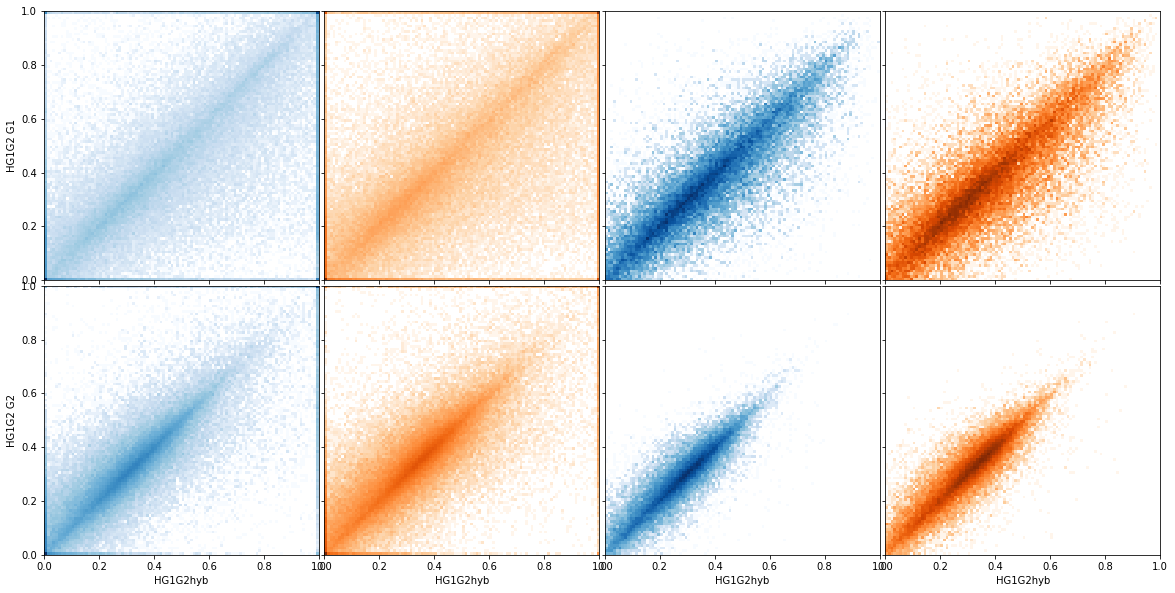

In [32]:
# Overall comparison of G1 G2
fig, ax = plt.subplots(2, 4, figsize=(20,10), gridspec_kw={'hspace':0.02, 'wspace':0.02})

# ax = axs.ravel() 
r = [0,1]
b = 100

mm = mask_HG1G2 & mask_sHG1G2


ax[0,0].hist2d( data.HG1G2_G1_g, data.sHG1G2_G1_g, density=True, range=[r,r], bins=b, cmap='Blues', norm='log' )
ax[0,1].hist2d( data.HG1G2_G1_r, data.sHG1G2_G1_r, density=True, range=[r,r], bins=b, cmap='Oranges', norm='log' )
ax[0,2].hist2d( data.HG1G2_G1_g[mm], data.sHG1G2_G1_g[mm], density=True, range=[r,r], bins=b, cmap='Blues', norm='log' )
ax[0,3].hist2d( data.HG1G2_G1_r[mm], data.sHG1G2_G1_r[mm], density=True, range=[r,r], bins=b, cmap='Oranges', norm='log' )

ax[1,0].hist2d( data.HG1G2_G2_g, data.sHG1G2_G2_g, density=True, range=[r,r], bins=b, cmap='Blues', norm='log' )
ax[1,1].hist2d( data.HG1G2_G2_r, data.sHG1G2_G2_r, density=True, range=[r,r], bins=b, cmap='Oranges', norm='log' )
ax[1,2].hist2d( data.HG1G2_G2_g[mm], data.sHG1G2_G2_g[mm], density=True, range=[r,r], bins=b, cmap='Blues', norm='log' )
ax[1,3].hist2d( data.HG1G2_G2_r[mm], data.sHG1G2_G2_r[mm], density=True, range=[r,r], bins=b, cmap='Oranges', norm='log' )

for a in ax[:,1:].ravel():
    a.set_yticklabels('')
for a in ax[0,:].ravel():
    a.set_xticklabels('')

ax[0,0].set_ylabel('HG1G2 G1')
ax[1,0].set_ylabel('HG1G2 G2')

for a in ax[1,:]:
    a.set_xlabel('HG1G2hyb')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'G1G2_comparison.png'), facecolor='white')

## RMS and Chi-square

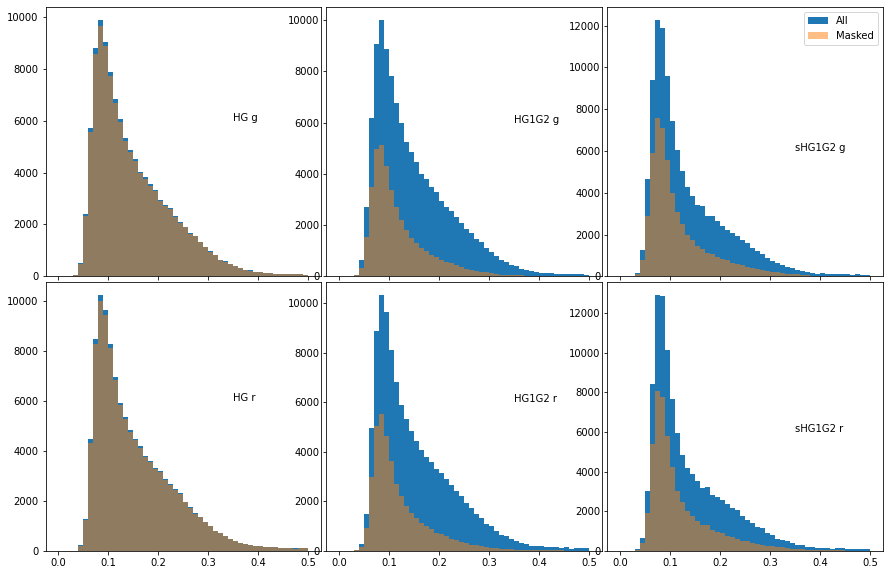

In [33]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10), gridspec_kw={'hspace':0.02, 'wspace':0.02})

r = [0,0.5]
b = 50

ax[0,0].hist( data.loc[:,'HG_rms_g'], range=r, bins=b, label='All')
ax[0,0].hist( data.loc[mask_HG,'HG_rms_g'], range=r, bins=b, label='Masked', alpha=0.5)
ax[0,0].text( 0.35, 6000, 'HG g')

ax[1,0].hist( data.loc[:,'HG_rms_r'], range=r, bins=b, label='All')
ax[1,0].hist( data.loc[mask_HG,'HG_rms_r'], range=r, bins=b, label='Masked', alpha=0.5)
ax[1,0].text( 0.35, 6000, 'HG r')


ax[0,1].hist( data.loc[:,'HG1G2_rms_g'], range=r, bins=b, label='All')
ax[0,1].hist( data.loc[mask_HG1G2,'HG1G2_rms_g'], range=r, bins=b, label='Masked', alpha=0.5)
ax[0,1].text( 0.35, 6000, 'HG1G2 g')

ax[1,1].hist( data.loc[:,'HG1G2_rms_r'], range=r, bins=b, label='All')
ax[1,1].hist( data.loc[mask_HG1G2,'HG1G2_rms_r'], range=r, bins=b, label='Masked', alpha=0.5)
ax[1,1].text( 0.35, 6000, 'HG1G2 r')


ax[0,2].hist( data.loc[:,'sHG1G2_rms_g'], range=r, bins=b, label='All')
ax[0,2].hist( data.loc[mask_sHG1G2,'sHG1G2_rms_g'], range=r, bins=b, label='Masked', alpha=0.5)
ax[0,2].text( 0.35, 6000, 'sHG1G2 g')

ax[1,2].hist( data.loc[:,'sHG1G2_rms_r'], range=r, bins=b, label='All')
ax[1,2].hist( data.loc[mask_sHG1G2,'sHG1G2_rms_r'], range=r, bins=b, label='Masked', alpha=0.5)
ax[1,2].text( 0.35, 6000, 'sHG1G2 r')
    

ax[0,2].legend(loc='upper right')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'rms_histo.png'), facecolor='white')

- Peak at 0.1 mag
- photometric quality of ZTF alerts @ 0.1mag

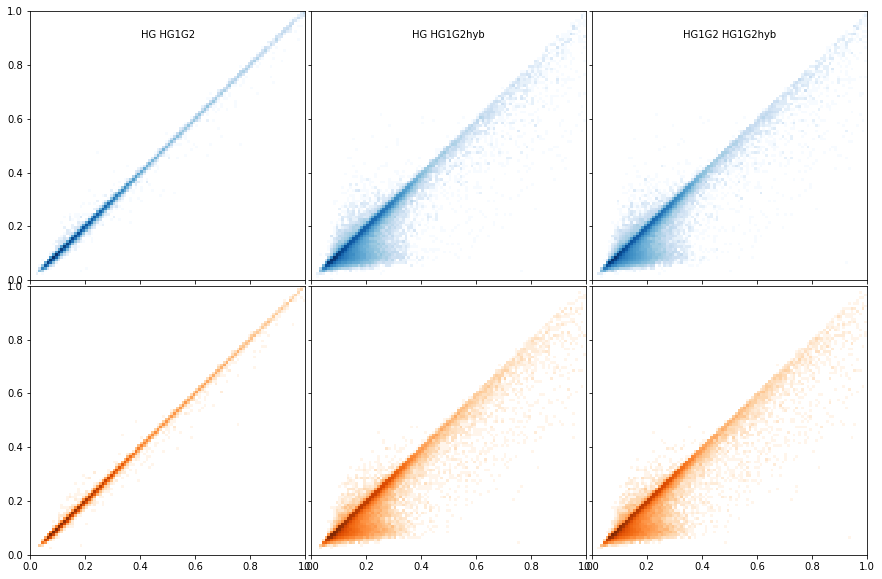

In [34]:
fig, ax = plt.subplots(2, 3, figsize=(15,10), gridspec_kw={'hspace':0.02, 'wspace':0.02})

r = [0,1]
b = 100

x = data['HG_rms_g']
y = data['HG1G2_rms_g']
ax[0,0].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Blues')

x = data['HG_rms_r']
y = data['HG1G2_rms_r']
ax[1,0].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Oranges')




x = data['HG_rms_g']
y = data['sHG1G2_rms_g']
ax[0,1].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Blues')

x = data['HG_rms_r']
y = data['sHG1G2_rms_r']
ax[1,1].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Oranges')




x = data['HG1G2_rms_g']
y = data['sHG1G2_rms_g']
ax[0,2].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Blues')

x = data['HG1G2_rms_r']
y = data['sHG1G2_rms_r']
ax[1,2].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Oranges')


ax[0,0].text( 0.5, 0.9, 'HG HG1G2', ha='center')
ax[0,1].text( 0.5, 0.9, 'HG HG1G2hyb', ha='center')
ax[0,2].text( 0.5, 0.9, 'HG1G2 HG1G2hyb', ha='center')


for a in ax[:,1:].ravel():
    a.set_yticklabels('')
for a in ax[0,:].ravel():
    a.set_xticklabels('')
    
fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'rms_comparison.png'), facecolor='white')

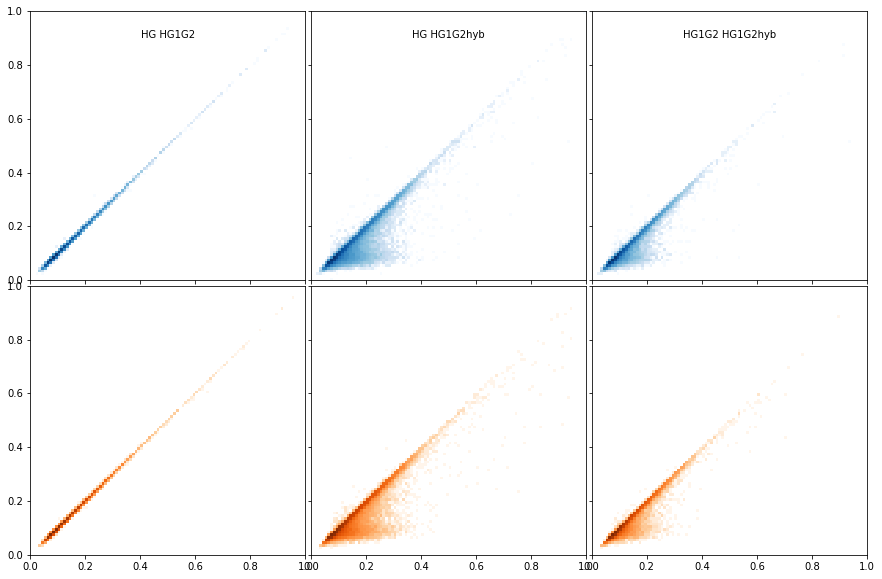

In [35]:
fig, ax = plt.subplots(2, 3, figsize=(15,10), gridspec_kw={'hspace':0.02, 'wspace':0.02})

r = [0,1]
b = 100

x = data.loc[mask_HG1G2,'HG_rms_g']
y = data.loc[mask_HG1G2,'HG1G2_rms_g']
ax[0,0].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Blues')

x = data.loc[mask_HG1G2,'HG_rms_r']
y = data.loc[mask_HG1G2,'HG1G2_rms_r']
ax[1,0].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Oranges')


x = data.loc[mask_sHG1G2,'HG_rms_g']
y = data.loc[mask_sHG1G2,'sHG1G2_rms_g']
ax[0,1].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Blues')

x = data.loc[mask_sHG1G2,'HG_rms_r']
y = data.loc[mask_sHG1G2,'sHG1G2_rms_r']
ax[1,1].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Oranges')


mm = mask_HG1G2 & mask_sHG1G2
x = data.loc[mm,'HG1G2_rms_g']
y = data.loc[mm,'sHG1G2_rms_g']
ax[0,2].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Blues')

x = data.loc[mm,'HG1G2_rms_r']
y = data.loc[mm,'sHG1G2_rms_r']
ax[1,2].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Oranges')

for a in ax[:,1:].ravel():
    a.set_yticklabels('')
for a in ax[0,:].ravel():
    a.set_xticklabels('')
    
ax[0,0].text( 0.5, 0.9, 'HG HG1G2', ha='center')
ax[0,1].text( 0.5, 0.9, 'HG HG1G2hyb', ha='center')
ax[0,2].text( 0.5, 0.9, 'HG1G2 HG1G2hyb', ha='center')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'rms_comparison_masked.png'), facecolor='white')

Text(0.1, 0.8, 'HG1G2 - sHG1G2')

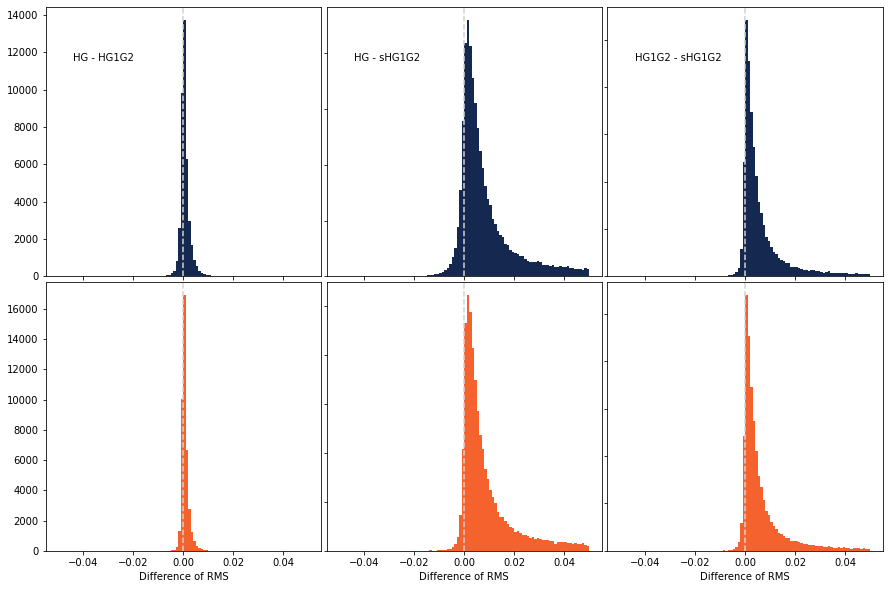

In [41]:
fig, ax = plt.subplots(2, 3, figsize=(15,10), gridspec_kw={'hspace':0.02, 'wspace':0.02})

r = [-0.05,0.05]
b = 100

x = data.loc[mask_HG1G2,'HG_rms_g']
y = data.loc[mask_HG1G2,'HG1G2_rms_g']
ax[0,0].hist( x-y, range=r, bins=b, color=fink_colors[0])

x = data.loc[mask_HG1G2,'HG_rms_r']
y = data.loc[mask_HG1G2,'HG1G2_rms_r']
ax[1,0].hist( x-y, range=r, bins=b, color=fink_colors[1])


x = data.loc[mask_sHG1G2,'HG_rms_g']
y = data.loc[mask_sHG1G2,'sHG1G2_rms_g']
ax[0,1].hist( x-y, range=r, bins=b, color=fink_colors[0])

x = data.loc[mask_sHG1G2,'HG_rms_r']
y = data.loc[mask_sHG1G2,'sHG1G2_rms_r']
ax[1,1].hist( x-y, range=r, bins=b, color=fink_colors[1])


mm = mask_HG1G2 & mask_sHG1G2
x = data.loc[mm,'HG1G2_rms_g']
y = data.loc[mm,'sHG1G2_rms_g']

x = data.loc[mm,'HG1G2_rms_r']
y = data.loc[mm,'sHG1G2_rms_r']
ax[0,2].hist( x-y, range=r, bins=b, color=fink_colors[0])
ax[1,2].hist( x-y, range=r, bins=b, color=fink_colors[1])


for a in ax[:,1:].ravel():
    a.set_yticklabels('')
for a in ax[0,:].ravel():
    a.set_xticklabels('')
for a in ax[1,:].ravel():
    a.set_xlabel('Difference of RMS')

for a in ax.ravel():
    a.axvline(0, linestyle='dashed', color='lightgrey' )
    
# ax[0,0].text( -0.04, 1000, 'HG HG1G2', ha='left')
# ax[0,1].text( -0.04, 1000, 'HG HG1G2hyb', ha='left')
# ax[0,2].text( -0.04, 1000, 'HG1G2 HG1G2hyb', ha='left')

ax[0,0].text( 0.1, 0.8, 'HG - HG1G2', transform=ax[0,0].transAxes)
ax[0,1].text( 0.1, 0.8, 'HG - sHG1G2', transform=ax[0,1].transAxes)
ax[0,2].text( 0.1, 0.8, 'HG1G2 - sHG1G2', transform=ax[0,2].transAxes)



- use that to get best and worst improvement

In [42]:

cols = ['sso_number','sso_name', 
        'minphase', 'maxphase', 'n_days', 'n_obs',
        'HG_H_r', 'HG_G_r', 'HG_rms_r', 
        'HG1G2_H_r', 'HG1G2_G1_r', 'HG1G2_G2_r', 'HG1G2_rms_r', 
        'sHG1G2_H_r', 'sHG1G2_G1_r', 'sHG1G2_G2_r', 'sHG1G2_rms_r']

improved = data.loc[mask_HG1G2 & mask_sHG1G2, cols]

improved_from_HG = improved.loc[(improved.HG_rms_r - improved.HG1G2_rms_r).sort_values(ascending=True).index, cols].tail(20)
improved_from_HG1G2 = improved.loc[(improved.HG1G2_rms_r - improved.sHG1G2_rms_r).sort_values(ascending=True).index, cols].tail(20)


# Spins

In [43]:
data.columns

Index(['ssnamenr', 'nmeasurements', 'ndays', 'params', 'number', 'name',
       'HG_H_g', 'HG_dH_g', 'HG_G_g', 'HG_dG_g',
       ...
       'spins.3.DEC0.value', 'spins.3.long.value', 'spins.3.lat.value',
       'spins.3.technique', 'spins.4.obliquity', 'spins.4.RA0.value',
       'spins.4.DEC0.value', 'spins.4.long.value', 'spins.4.lat.value',
       'spins.4.technique'],
      dtype='object', length=151)

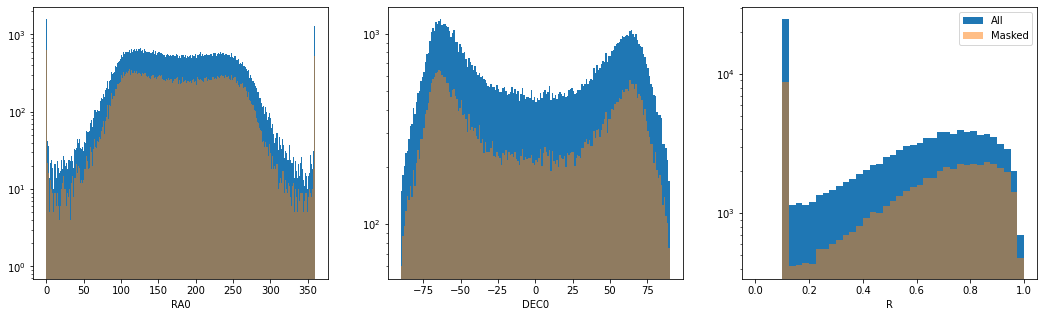

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

r = [0,360]
b = 360
ax[0].hist( data.loc[:,'sHG1G2_alpha0'], range=r, bins=b, label='All')
ax[0].hist( data.loc[mask_sHG1G2,'sHG1G2_alpha0'], range=r, bins=b, label='Masked', alpha=0.5)

r = [-90,90]
b = 180
ax[1].hist( data.loc[:,'sHG1G2_delta0'], range=r, bins=b, label='All')
ax[1].hist( data.loc[mask_sHG1G2,'sHG1G2_delta0'], range=r, bins=b, label='Masked', alpha=0.5)

r = [0,1]
b = 40
ax[2].hist( data.loc[:,'sHG1G2_R'], range=r, bins=b, label='All')
ax[2].hist( data.loc[mask_sHG1G2,'sHG1G2_R'], range=r, bins=b, label='Masked', alpha=0.5)


ax[0].set_xlabel(f'RA0')
ax[1].set_xlabel(f'DEC0')
ax[2].set_xlabel(f'R')

for a in ax:
    a.set_yscale('log')
ax[2].legend(loc='upper right')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'spin_histo.png'), facecolor='white')

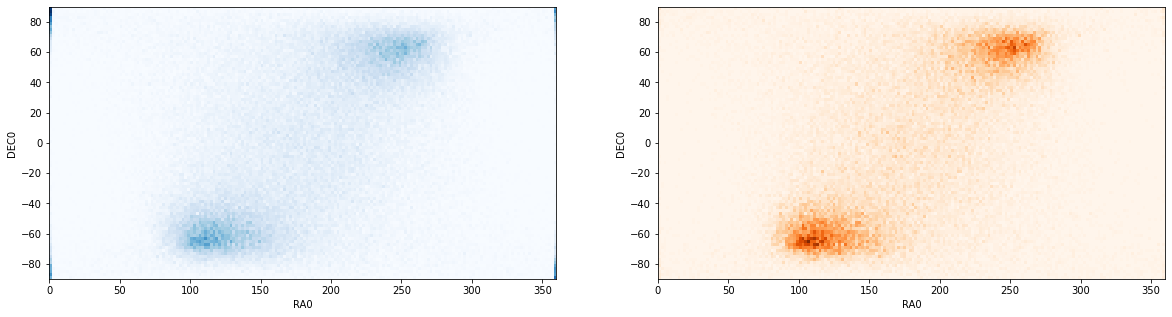

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

r = [[0,360],[-90,90]]
b = [180,90]

# ax.scatter( data.loc[:,'sHG1G2_alpha0'], data.loc[:,'sHG1G2_delta0'] )
ax[0].hist2d( data.loc[:,'sHG1G2_alpha0'], data.loc[:,'sHG1G2_delta0'], range=r, bins=b, cmap='Blues' )

ax[1].hist2d( data.loc[mask_sHG1G2&maskSpin,'sHG1G2_alpha0'], data.loc[mask_sHG1G2&maskSpin,'sHG1G2_delta0'], range=r, bins=b, cmap='Oranges' )

for a in ax:
    a.set_xlabel(f'RA0')
    a.set_ylabel(f'DEC0')


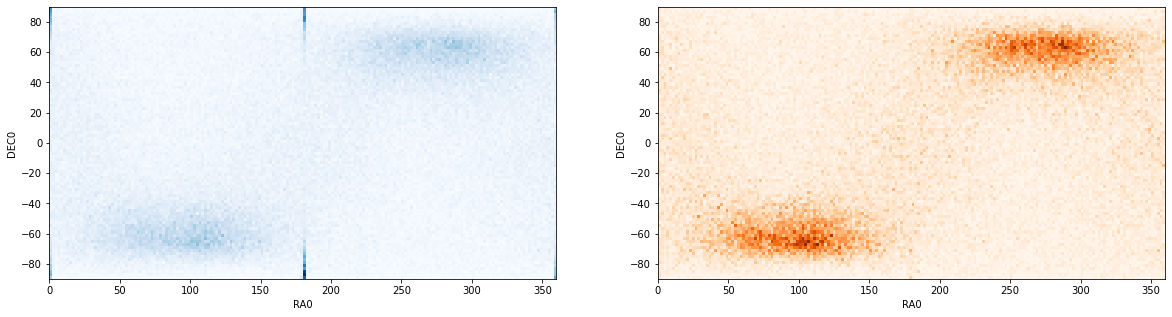

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

r = [[0,360],[-90,90]]
b = [180,90]

# Flip half spins
data_flipped = data.copy()
cond = (data_flipped.index %2 ==0 )
xax = 'sHG1G2_alpha0'
yax = 'sHG1G2_delta0'

data_flipped.loc[cond,xax] = (data.loc[cond,xax]+180) % 360
data_flipped.loc[cond,yax] = -data.loc[cond,yax]

# ax.scatter( data.loc[:,'sHG1G2_alpha0'], data.loc[:,'sHG1G2_delta0'] )
ax[0].hist2d( data_flipped.loc[:,'sHG1G2_alpha0'], data_flipped.loc[:,'sHG1G2_delta0'], range=r, bins=b, cmap='Blues' )

ax[1].hist2d( data_flipped.loc[mask_sHG1G2&maskSpin,'sHG1G2_alpha0'], data_flipped.loc[mask_sHG1G2&maskSpin,'sHG1G2_delta0'], range=r, bins=b, cmap='Oranges' )

for a in ax:
    a.set_xlabel(f'RA0')
    a.set_ylabel(f'DEC0')


# Uncertainties on parameters

In [48]:
data.columns[:90]

Index(['ssnamenr', 'nmeasurements', 'ndays', 'params', 'number', 'name',
       'HG_H_g', 'HG_dH_g', 'HG_G_g', 'HG_dG_g', 'HG_rms_g', 'HG_H_r',
       'HG_dH_r', 'HG_G_r', 'HG_dG_r', 'HG_rms_r', 'minphase', 'maxphase',
       'n_days', 'n_obs', 'HG_rms', 'HG_chi2red', 'HG_status', 'HG_fit',
       'HG1G2_H_g', 'HG1G2_dH_g', 'HG1G2_G1_g', 'HG1G2_dG1_g', 'HG1G2_G2_g',
       'HG1G2_dG2_g', 'HG1G2_rms_g', 'HG1G2_H_r', 'HG1G2_dH_r', 'HG1G2_G1_r',
       'HG1G2_dG1_r', 'HG1G2_G2_r', 'HG1G2_dG2_r', 'HG1G2_rms_r', 'HG1G2_rms',
       'HG1G2_chi2red', 'HG1G2_status', 'HG1G2_fit', 'sHG1G2_max_phase_1',
       'sHG1G2_kurtosis_delta_RA_cos_DEC', 'sHG1G2_max_phase_2',
       'sHG1G2_max_cos_lambda', 'sHG1G2_fit', 'sHG1G2_R',
       'sHG1G2_min_cos_lambda', 'sHG1G2_kurtosis_delta_DEC', 'sHG1G2_n_obs',
       'sHG1G2_skew_delta_DEC', 'sHG1G2_err_G2_1', 'sHG1G2_err_G1_2',
       'sHG1G2_skew_delta_RA_cos_DEC', 'sHG1G2_n_days', 'sHG1G2_err_G1_1',
       'sHG1G2_rms', 'sHG1G2_err_G2_2', 'sHG1G2_G2_g',

Text(0.5, 0, 'dR')

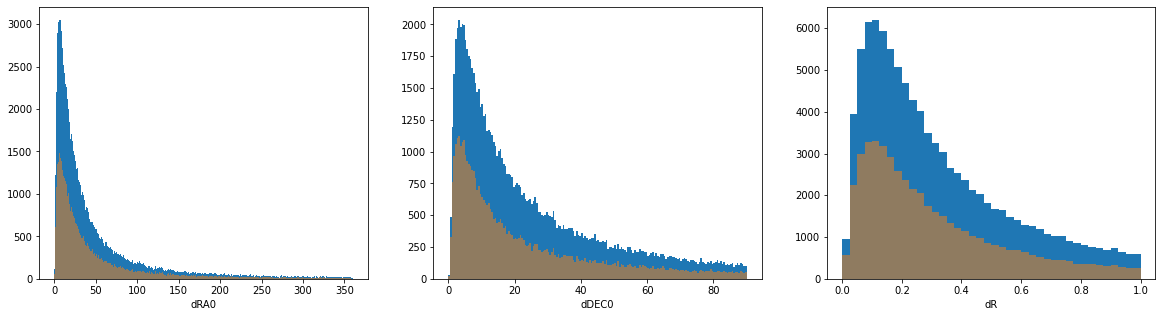

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))


r = [0,360]
b = 360
ax[0].hist( data.loc[:,'sHG1G2_err_alpha0'], range=r, bins=b, label='All')
ax[0].hist( data.loc[mask_sHG1G2,'sHG1G2_err_alpha0'], range=r, bins=b, label='Masked', alpha=0.5)

r = [0,90]
b = 180
ax[1].hist( data.loc[:,'sHG1G2_err_delta0'], range=r, bins=b, label='All')
ax[1].hist( data.loc[mask_sHG1G2,'sHG1G2_err_delta0'], range=r, bins=b, label='Masked', alpha=0.5)

r = [0,1]
b = 40
ax[2].hist( data.loc[:,'sHG1G2_err_R'], range=r, bins=b, label='All')
ax[2].hist( data.loc[mask_sHG1G2,'sHG1G2_err_R'], range=r, bins=b, label='Masked', alpha=0.5)


ax[0].set_xlabel(f'dRA0')
ax[1].set_xlabel(f'dDEC0')
ax[2].set_xlabel(f'dR')